In [1]:
import sys
sys.path.append("..")
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras import layers as L
import tarfile

Using TensorFlow backend.


In [2]:
cascade_face = cv2.CascadeClassifier('frontalface.xml')
eye_cascade = cv2.CascadeClassifier('frontaleyes.xml') 

In [3]:
def detect_faces(cascade, test_image):
    image_copy = test_image.copy()
    faces_rect = cascade.detectMultiScale(image_copy, minSize=(50, 50), scaleFactor=1.1, minNeighbors=10)
    #eyes_rect= eye_cascade.detectMultiScale(image_copy)
    if (faces_rect==()): # si no reconoce cara
        return 0
      
    else:
        for (x, y, w, h) in faces_rect:
            r = max(w, h) / 1.17
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)
    faceimg = image_copy[ny:ny+nr+10, nx:nx+nr+10]

    return faceimg

In [4]:
def take_images():
    res = []
    tmp = []
    with tarfile.open('raw.tgz') as f:
        for m in tqdm.tqdm(f.getmembers()):
            try:
                img = cv2.imdecode(np.asarray(bytearray(f.extractfile(m).read()), dtype=np.uint8), 1)  
                faces = detect_faces(cascade_face, img)
                img_rgb = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_rgb, (128, 128))
                tmp.append(new_array)
            except:  
                pass
    print(len(tmp))
    for i in tqdm.tqdm(tmp):
        eyes_rect= eye_cascade.detectMultiScale(i, minNeighbors=2, scaleFactor=1.1)

        if (eyes_rect!=()):
            res.append(i)
            horizontal_img = cv2.flip(i, 1 )
            res.append(horizontal_img)
    print(len(res))
    return res

In [5]:
training_dat =take_images()
training_dat = np.float32(training_dat)/255.

  0%|          | 0/10736 [00:00<?, ?it/s]/home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
  2%|▏         | 76/3054 [00:00<00:03, 752.78it/s]

3054


100%|██████████| 3054/3054 [00:04<00:00, 713.55it/s]


2624


In [6]:
IMG_SHAPE_ban=training_dat.shape[1:]
IMG_SHAPE_ban

(128, 128, 3)

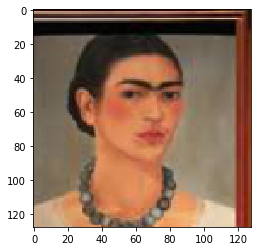

In [7]:
plt.imshow(training_dat[np.random.randint(training_dat.shape[0])], cmap="gray", interpolation="none");

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
tf.test.gpu_device_name()
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [10]:

#red generadora
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(512*8*8, activation='elu'))
generator.add(L.Reshape((8, 8,512)))
generator.add(L.Deconv2D(254,kernel_size=(9,9),activation='elu'))
generator.add(L.Deconv2D(128,kernel_size=(9,9),activation='elu'))
generator.add(L.UpSampling2D(size=(5,5)))
generator.add(L.Deconv2D(64,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(16,kernel_size=4,activation='elu'))
generator.add(L.Conv2D(3,kernel_size=2,activation=None))
generator.summary()

W0808 21:27:44.605404 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 21:27:44.607966 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 21:27:44.609848 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 21:27:44.660057 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             8421376   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 254)       10534142  
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 128)       2633600   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 120, 120, 128)     0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 123, 123, 64)      131136    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 126, 126, 32)      32800     
__________

In [11]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE_ban))

discriminator.add(L.Conv2D(8, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(16, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(32, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(64, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))


# <build discriminator body>

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


discriminator.summary()

W0808 21:27:46.169728 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 21:27:46.170463 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0808 21:27:46.674330 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0808 21:27:46.767261 139923136599872 deprecation_wrapper.py:119] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tenso

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 8)       32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
__________

In [12]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE_ban))

logp_real = discriminator(real_data)

generated_data = generator(noise) #<gen(noise)>

logp_gen = discriminator(generated_data) #<log P(real | gen(noise))




In [13]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
 
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

W0808 21:27:47.527855 139923136599872 deprecation.py:323] From /home/david/miniconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
########################
###generator training###
########################

g_loss = tf.reduce_mean(logp_gen[:,0]) # <generator loss>

gen_optimizer =tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)
    

In [18]:
s.run(tf.global_variables_initializer())

In [19]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(training_dat.shape[0]), size=bsize)
    return training_dat[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(training_dat),np.max(training_dat))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

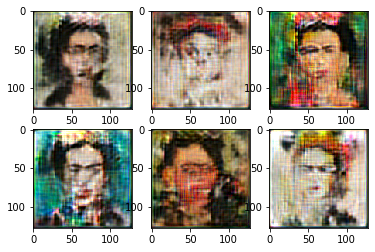

100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


In [23]:
from IPython import display
for epoch in tqdm.tqdm(range(100)):
  
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
  
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
  
    s.run(gen_optimizer,feed_dict)
  
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
   #     sample_probas(1000)

In [21]:
images = generator.predict(sample_noise_batch(100))

In [ ]:
#5400
#5600

In [ ]:
discriminator.save("discriminator128_1.h5")
generator.save("generator128_1.h5")

In [22]:
for i in range(0,99):
    plt.imshow(images[i], cmap="gray")
    plt.savefig('./op128/image{}.png'.format(i), dpi=200, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.clf()

W0809 00:07:35.069011 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:35.259552 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:35.487537 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:35.684607 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:35.874505 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:36.062865 139923136599872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 00:07:36.251312 139923

<Figure size 432x288 with 0 Axes>